In [109]:
import requests
import json
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

In [110]:
client = Socrata("data.cityofnewyork.us", "nw0pZM57EWuIKqCqQvWUFqAE0")
results = client.get("uvbq-3m68", limit = 500000, where="issue_date like'%/2018'")
client_df = pd.DataFrame.from_records(results)
client_df.head()

,amount_due,county,fine_amount,interest_amount,issue_date,issuing_agency,judgment_entry_date,license_type,payment_amount,penalty_amount,plate,precinct,reduction_amount,state,summons_image,summons_number,violation,violation_status,violation_time
0,0,Q,65,0,07/17/2018,TRAFFIC,NaN,IRP,65,0,35555PC,107,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8583283734,INSP. STICKER-EXPIRED/MISSING,HEARING HELD-GUILTY,02:19P
1,165.34,BX,95,10.34,07/22/2018,POLICE DEPARTMENT,11/15/2018,PAS,0,60,HCE373,047,0,VT,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,1436354780,OBSTRUCTING DRIVEWAY,NaN,04:55A
2,0,BK,50,0,12/31/2018,DEPARTMENT OF TRANSPORTATION,NaN,OMT,75,25,T648698C,000,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,5104987474,FAILURE TO STOP AT RED LIGHT,NaN,09:36A
3,0,BK,50,0,12/31/2018,DEPARTMENT OF TRANSPORTATION,NaN,PAS,50,0,GSN6575,000,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,5104987413,FAILURE TO STOP AT RED LIGHT,NaN,09:31A
4,0,K,115,0,09/05/2018,TRAFFIC,NaN,COM,0,0,11246MC,083,115,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8538637927,NO STANDING-DAY/TIME LIMITS,HEARING HELD-NOT GUILTY,01:45P


In [111]:
client_df.columns

Index(['amount_due', 'county', 'fine_amount', 'interest_amount', 'issue_date',
       'issuing_agency', 'judgment_entry_date', 'license_type',
       'payment_amount', 'penalty_amount', 'plate', 'precinct',
       'reduction_amount', 'state', 'summons_image', 'summons_number',
       'violation', 'violation_status', 'violation_time'],
      dtype='object')

In [112]:
client_df["amount_due"] = pd.to_numeric(client_df["amount_due"])
client_df["fine_amount"] = pd.to_numeric(client_df["fine_amount"])
client_df["interest_amount"] = pd.to_numeric(client_df["interest_amount"])
client_df["payment_amount"] = pd.to_numeric(client_df["payment_amount"])
client_df["penalty_amount"] = pd.to_numeric(client_df["penalty_amount"])
client_df["reduction_amount"] = pd.to_numeric(client_df["reduction_amount"])

In [113]:
# Frequency of violations by license plate

frequency_plate = client_df[["plate", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount",
                             "summons_number", "state"]]

frequency_plate_grouping = frequency_plate.groupby(["plate"])



#NOTES
#frequency_plate_grouping = frequency_plate.groupby(["plate"])["summons_number"].count()
#df = pd.DataFrame(data=frequency_plate_grouping)
#df_sorted = df.sort_values("summons_number", ascending=False)
#df_sorted

In [114]:
meow = frequency_plate_grouping["summons_number"].count()
meow.head()

plate
000002N    1
00004CH    1
00006CF    1
0001DBD    1
0001QDD    1
Name: summons_number, dtype: int64

In [115]:
woof = frequency_plate_grouping["fine_amount"].sum()
woof.head()

plate
000002N     45
00004CH    115
00006CF     95
0001DBD     95
0001QDD     95
Name: fine_amount, dtype: int64

In [160]:
frequency = pd.DataFrame({"Total Violation Cost": woof, "Frequency": meow })
frequency_sorted = frequency.sort_values("Frequency", ascending=False)
frequency_sorted.head()

,Total Violation Cost,Frequency
plate,,
BLANKPLATE,17445,219
34914PC,12270,126
48703PC,7190,96
KNX6784,10055,88
43176PC,8380,80


In [185]:
bins = [0,2,250]
groups = ["Up to 2 Tickets", "More than 2 tickets"]

frequency_sorted["breakdown"] = pd.cut(frequency_sorted["Frequency"], bins, labels=groups)
frequency_sorted.head()

,Total Violation Cost,Frequency,breakdown
plate,,,
BLANKPLATE,17445,219,More than 2 tickets
34914PC,12270,126,More than 2 tickets
48703PC,7190,96,More than 2 tickets
KNX6784,10055,88,More than 2 tickets
43176PC,8380,80,More than 2 tickets


In [186]:
frequency_sorted.columns

Index(['Total Violation Cost', 'Frequency', 'breakdown'], dtype='object')

In [187]:
breakdown_variable = frequency_sorted["breakdown"].value_counts()
breakdown_variable

Up to 2 Tickets        335129
More than 2 tickets     24025
Name: breakdown, dtype: int64

In [214]:
groupedby_breakdown = frequency_sorted.groupby(["breakdown"])
moo = groupedby_breakdown["Total Violation Cost"].sum()
moo

breakdown
Up to 2 Tickets        27116400
More than 2 tickets     9858615
Name: Total Violation Cost, dtype: int64

In [227]:
df_for_graph = pd.DataFrame({"Total $ Generated": moo})
df_for_graph.head()

,Total $ Generated
breakdown,
Up to 2 Tickets,27116400
More than 2 tickets,9858615


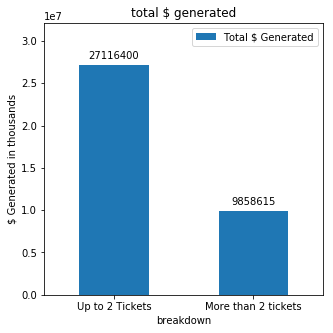

<Figure size 432x288 with 0 Axes>

In [236]:
ax = df_for_graph.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("$ Generated in thousands")

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()
                  
plt.tight_layout()

In [124]:
# pies by state
#timeline of getting tickets
#top five flyers made $ vs 10,000 bottom others (do two buckets for visualization)


In [ ]:
#Frequency of violations by state



In [ ]:
# Total $ amount of violations by license plate
# Total $ amount of violations by state